In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
# ------------------------- Data Preprocessing Function -------------------------
def preprocess_data(df, label_col="label"):
    """
    Preprocess the dataset:
    1. Separate label from features.
    2. Handle NaN and infinite values.
    3. Remove zero-variance columns.
    4. Scale features using StandardScaler.
    
    Returns:
    - X_scaled: Processed feature matrix.
    - y: Labels.
    """
    
    # Separate label and features
    y = df[label_col].values
    X = df.drop(columns=[label_col])
    
    # Keep only numeric columns
    X = X.select_dtypes(include=[np.number])

    # Replace inf/-inf with NaN and then fill NaNs with 0
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Remove zero-variance columns
    variances = X.var(axis=0)
    cols_to_keep = variances[variances != 0].index
    X = X[cols_to_keep]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y



In [3]:
# Load the dataset
print("Loading dataset...")
df = pd.read_csv("extracted_features.csv")  # Ensure the file exists in the working directory

# Preprocess data
print("Preprocessing data...")
X_preprocessed, y_preprocessed = preprocess_data(df, label_col="Category")

print(f"Feature matrix shape after preprocessing: {X_preprocessed.shape}\n")


Loading dataset...
Preprocessing data...
Feature matrix shape after preprocessing: (20000, 500)



In [4]:
# ------------------------- Train-Test Split -------------------------
print("Splitting dataset into train and test sets...")
x_train, x_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)



Splitting dataset into train and test sets...


In [6]:

# ------------------------- Apply Gaussian Mixture Model (GMM) -------------------------
print("Applying Gaussian Mixture Model (GMM)...")

# Determine the number of clusters based on unique labels
n_components = len(np.unique(y_preprocessed))

# Initialize GMM
gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=100, verbose=2)

#fitting the model
gmm.fit(x_train)

print(f"\nNumber of Components: {n_components}")
print(f"GMM Converged: {gmm.converged_}\n")

# Assign GMM cluster labels to training and test data
gmm_labels_train = gmm.predict(x_train)
gmm_labels_test = gmm.predict(x_test)


Applying Gaussian Mixture Model (GMM)...
Initialization 0
Initialization converged. time lapse 331.66120s	 lower bound 2430.87674.

Number of Components: 250
GMM Converged: True



In [7]:
# ------------------------- Train KNN Classifier -------------------------
print("Training KNN classifier...")

# Define range of k values to test
k_values = range(1, 31)
accuracies = []

# Train KNN for different values of k with a progress bar
with tqdm(total=len(k_values), desc="Training KNN", unit="k-value") as pbar:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, gmm_labels_train)  # Train KNN using GMM cluster labels
        y_pred = knn.predict(x_test)  # Predict on test data
        acc = accuracy_score(gmm_labels_test, y_pred)
        accuracies.append(acc)
        pbar.update(1)

# Find the best k
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

print(f"\nBest k: {best_k}, Best Accuracy: {best_accuracy:.2f}\n")

Training KNN classifier...


Training KNN: 100%|██████████| 30/30 [00:24<00:00,  1.25k-value/s]


Best k: 19, Best Accuracy: 0.52



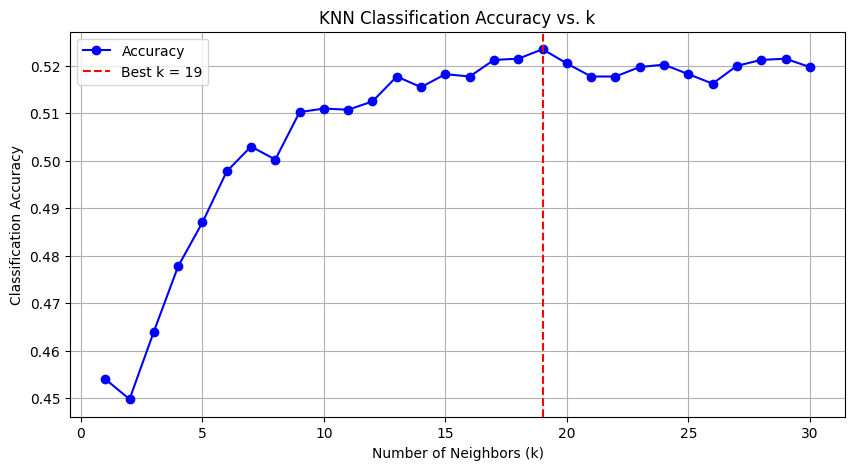

In [8]:
# ------------------------- Plot Accuracy vs. k -------------------------
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Classification Accuracy")
plt.title("KNN Classification Accuracy vs. k")
plt.legend()
plt.grid()
plt.show()